In [1]:
# This command will install the correct numpy version for this notebook's environment
%pip install numpy==1.26.4 --force-reinstall

  Using cached numpy-1.26.4-cp313-cp313-macosx_15_0_arm64.whl
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Core Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_ta as ta
import joblib
import os

# Scikit-learn for modeling
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# --- ⚠️ Financial Disclaimer ---
print("="*80)
print("⚠️  IMPORTANT DISCLAIMER: This is a learning project, not financial advice. ⚠️")
print("Stock market prediction is extremely difficult. Do not use this agent with real money.")
print("="*80)

⚠️  IMPORTANT DISCLAIMER: This is a learning project, not financial advice. ⚠️
Stock market prediction is extremely difficult. Do not use this agent with real money.


In [3]:
# --- Configuration ---
TICKER = "TSLA"  # Or whatever ticker you want
TRAINING_PERIOD = "10y"
MODEL_FILE_NAME = f"{TICKER}_predictor_model.joblib"

print(f"Configuration set for Ticker: {TICKER}")

Configuration set for Ticker: TSLA


In [4]:
def create_features(df):
    """Creates technical analysis features on the dataframe."""
    df = df.copy()

    # Technical Indicators using pandas_ta
    df.ta.sma(length=20, append=True)
    df.ta.ema(length=50, append=True)
    df.ta.rsi(length=14, append=True)
    df.ta.macd(fast=12, slow=26, signal=9, append=True)
    df.ta.bbands(length=20, append=True) # Bollinger Bands
    df.ta.atr(length=14, append=True) # Average True Range

    # Create the target variable: 1 if the next day's close is higher, 0 otherwise
    df['target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

    # Drop rows with NaN values created by indicators/shifting
    df.dropna(inplace=True)

    return df

In [10]:
# ==============================================================================
#                 THE BULLETPROOF FIX: NUKE AND REBUILD
# ==============================================================================

# 1. Fetch Data (we still need the raw data)
print(f"Fetching {TRAINING_PERIOD} of historical data for {TICKER}...")
data = yf.download(
    TICKER,
    period=TRAINING_PERIOD,
    interval="1d",
    progress=False
)

if data.empty:
    print(f"Error: No data found for {TICKER}.")
else:
    print("Data fetched successfully.")

    # 2. NUKE AND REBUILD: Create a brand new, guaranteed-clean DataFrame.
    print("\nRebuilding DataFrame to ensure clean columns...")

    # Create an empty DataFrame but keep the original date index
    clean_df = pd.DataFrame(index=data.index)

    # Manually copy over ONLY the columns we need.
    # Pandas is smart enough to find the right data even with a MultiIndex.
    clean_df['Open'] = data['Open']
    clean_df['High'] = data['High']
    clean_df['Low'] = data['Low']
    clean_df['Close'] = data['Close']
    clean_df['Volume'] = data['Volume']

    print("Clean DataFrame created successfully.")
    print("Columns are now guaranteed to be simple strings:")
    print(clean_df.columns)

    # 3. Create Features using the GUARANTEED CLEAN DataFrame
    print("\nEngineering features...")
    # We pass 'clean_df' to the function, NOT the original 'data'.
    featured_data = create_features(clean_df)
    print("Features engineered successfully.")

    # Display the final result
    display(featured_data.head())

Fetching 10y of historical data for TSLA...


/var/folders/nb/l0pg_9815k993qn2p6z93clw0000gn/T/ipykernel_13042/3653702941.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(


Data fetched successfully.

Rebuilding DataFrame to ensure clean columns...
Clean DataFrame created successfully.
Columns are now guaranteed to be simple strings:
Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

Engineering features...
Features engineered successfully.


,Open,High,Low,Close,Volume,SMA_20,EMA_50,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,ATRr_14,target
Date,,,,,,,,,,,,,,,,,,
2015-09-04,16.059334,16.272667,15.880000,16.128668,55338000,16.081133,17.029253,47.407798,-0.241057,0.109636,-0.350693,14.648656,16.081133,17.513611,17.815630,0.516592,0.747105,1
2015-09-08,16.336666,16.610666,16.270000,16.544666,47073000,16.104566,17.010250,51.125865,-0.192289,0.126723,-0.319012,14.657928,16.104566,17.551205,17.965569,0.652111,0.727691,1
2015-09-09,16.803333,16.950001,16.553333,16.594000,50862000,16.143033,16.993926,51.563193,-0.147954,0.136846,-0.284801,14.687326,16.143033,17.598741,18.035118,0.654896,0.704128,0
2015-09-10,16.482000,16.714666,16.355333,16.565332,40635000,16.177400,16.977119,51.276066,-0.113820,0.136785,-0.250604,14.715901,16.177400,17.638899,18.068403,0.632717,0.678966,1
2015-09-11,16.509333,16.682667,16.315332,16.682667,35262000,16.203166,16.965572,52.443323,-0.076419,0.139348,-0.215767,14.725208,16.203166,17.681125,18.242839,0.662217,0.656260,1


In [11]:
# We want to predict the 'target' using all other columns except these
features_to_exclude = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'target']
features = [col for col in featured_data.columns if col not in features_to_exclude]

X = featured_data[features]
y = featured_data['target']

print(f"Training with {len(features)} features:")
print(features)

Training with 12 features:
['SMA_20', 'EMA_50', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0', 'ATRr_14']



--- Evaluating Model with Time Series Cross-Validation ---
Fold 1 -> Accuracy: 0.522, Precision (for 'UP'): 0.509
Fold 2 -> Accuracy: 0.461, Precision (for 'UP'): 0.488
Fold 3 -> Accuracy: 0.488, Precision (for 'UP'): 0.542
Fold 4 -> Accuracy: 0.507, Precision (for 'UP'): 0.521
Fold 5 -> Accuracy: 0.520, Precision (for 'UP'): 0.519

--- Final Test Set Evaluation (on the most recent data) ---
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.44      0.47       204
           1       0.52      0.60      0.56       206

    accuracy                           0.52       410
   macro avg       0.52      0.52      0.52       410
weighted avg       0.52      0.52      0.52       410


Confusion Matrix:


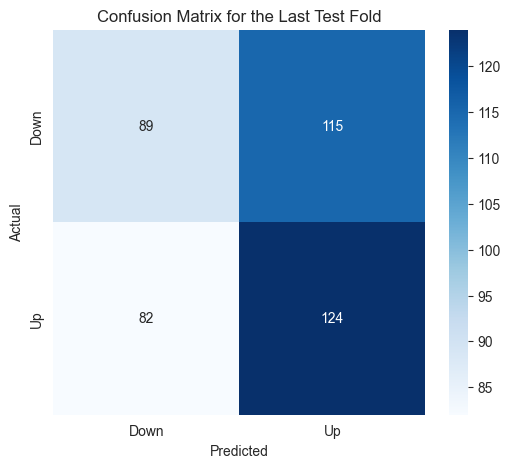

In [12]:
# Use TimeSeriesSplit for cross-validation on time-series data
tscv = TimeSeriesSplit(n_splits=5)
model = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)

print("\n--- Evaluating Model with Time Series Cross-Validation ---")
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, zero_division=0)

    print(f"Fold {i+1} -> Accuracy: {accuracy:.3f}, Precision (for 'UP'): {precision:.3f}")

print("\n--- Final Test Set Evaluation (on the most recent data) ---")
print("Classification Report:")
print(classification_report(y_test, predictions))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for the Last Test Fold')
plt.show()

In [13]:
print("--- Training Final Model on All Available Data ---")
model.fit(X, y)

# Save the model AND the list of features it was trained on in a single file
model_payload = {'model': model, 'features': features}
joblib.dump(model_payload, MODEL_FILE_NAME)

print(f"\n✅ Model trained and saved as '{MODEL_FILE_NAME}'")

--- Training Final Model on All Available Data ---

✅ Model trained and saved as 'TSLA_predictor_model.joblib'


In [17]:
# ==============================================================================
#           THE FINAL, FINAL, CORRECTED get_live_prediction FUNCTION
# ==============================================================================

def get_live_prediction(ticker_symbol):
    """Loads the model and makes a prediction for the given ticker."""
    model_filename = f"{ticker_symbol}_predictor_model.joblib"

    # 1. Load the Model
    try:
        model_payload = joblib.load(model_filename)
        model = model_payload['model']
        features = model_payload['features']
        print(f"✅ Model for {ticker_symbol} loaded successfully.")
    except FileNotFoundError:
        print(f"❌ Error: Model file '{model_filename}' not found.")
        print("Please run the training cells first.")
        return

    # 2. Fetch latest data
    print("Fetching new data...")
    data = yf.download(
        ticker_symbol,
        period="100d",
        interval="1d",
        progress=False
    )

    if data.empty:
        print("Could not fetch data.")
        return

    # Rebuild the DataFrame to ensure its columns are clean
    print("Rebuilding DataFrame to ensure clean columns...")
    clean_df = pd.DataFrame(index=data.index)
    clean_df['Open'] = data['Open']
    clean_df['High'] = data['High']
    clean_df['Low'] = data['Low']
    clean_df['Close'] = data['Close']
    clean_df['Volume'] = data['Volume']
    print("Clean DataFrame created successfully.")

    # 3. Engineer Features on the GUARANTEED CLEAN DataFrame
    data_feat = clean_df.copy()
    data_feat.ta.sma(length=20, append=True)
    data_feat.ta.ema(length=50, append=True)
    data_feat.ta.rsi(length=14, append=True)
    data_feat.ta.macd(fast=12, slow=26, signal=9, append=True)
    data_feat.ta.bbands(length=20, append=True)
    data_feat.ta.atr(length=14, append=True)
    data_feat.dropna(inplace=True)

    # 4. Get the most recent data point for prediction
    last_row = data_feat[features].iloc[[-1]]

    # 5. Make Prediction
    prediction = model.predict(last_row)[0]
    prediction_proba = model.predict_proba(last_row)[0]

    # --- THIS IS THE CORRECTED LINE ---
    # Get the last close price from our clean DataFrame.
    current_price = clean_df['Close'].iloc[-1]
    # ------------------------------------

    # 6. Display Results
    print("\n" + "="*50)
    print(f"Prediction for: {ticker_symbol}")
    print(f"Last Close Price: ${current_price:.2f}") # This will now work

    if prediction == 1:
        confidence = prediction_proba[1]
        print(f"Prediction: 📈 UP (for the next trading day)")
        print(f"Confidence: {confidence:.2%}")
    else:
        confidence = prediction_proba[0]
        print(f"Prediction: 📉 DOWN (for the next trading day)")
        print(f"Confidence: {confidence:.2%}")
    print("="*50)

# --- Execute the prediction function ---
get_live_prediction(TICKER)

✅ Model for TSLA loaded successfully.
Fetching new data...
Rebuilding DataFrame to ensure clean columns...
Clean DataFrame created successfully.

Prediction for: TSLA
Last Close Price: $327.55
Prediction: 📉 DOWN (for the next trading day)
Confidence: 82.00%


/var/folders/nb/l0pg_9815k993qn2p6z93clw0000gn/T/ipykernel_13042/184635294.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
